This short introduction uses [Keras](https://www.tensorflow.org/guide/keras/overview) to:

1. Build a neural network that classifies images.
2. Train this neural network.
3. And, finally, evaluate the accuracy of the model.

This is a [Google Colaboratory](https://colab.research.google.com/notebooks/welcome.ipynb) notebook file. Python programs are run directly in the browser—a great way to learn and use TensorFlow. To follow this tutorial, run the notebook in Google Colab by clicking the button at the top of this page.

1. In Colab, connect to a Python runtime: At the top-right of the menu bar, select *CONNECT*.
2. Run all the notebook code cells: Select *Runtime* > *Run all*.

Download and install TensorFlow 2. Import TensorFlow into your program:

Note: Upgrade `pip` to install the TensorFlow 2 package. See the [install guide](https://www.tensorflow.org/install) for details.

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random   

Load and prepare the [MNIST dataset](http://yann.lecun.com/exdb/mnist/). Convert the samples from integers to floating-point numbers:

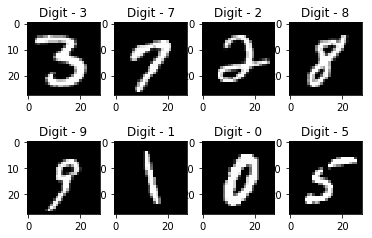

In [ ]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()


Build the `tf.keras.Sequential` model by stacking layers. Choose an optimizer and loss function for training:

In [ ]:
print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

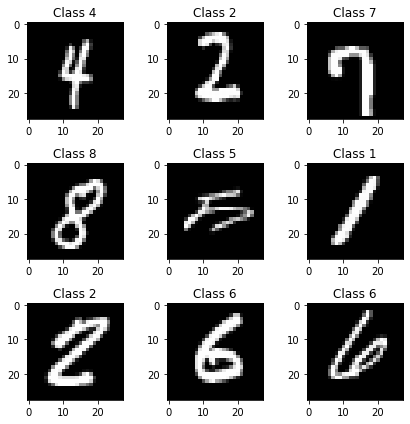

In [ ]:
plt.rcParams['figure.figsize'] = (6,6) # Make the figures a bit bigger

for i in range(9):
    plt.subplot(3,3,i+1)
    num = random.randint(0, len(x_train))
    plt.imshow(x_train[num], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[num]))
    
plt.tight_layout()

Let's examine a single digit a little closer, and print out the array representing the last digit.

In [ ]:
# just a little function for pretty printing a matrix
def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

# now print!        
matprint(x_train[num])

Each pixel is an 8-bit integer from 0-255. 0 is full black, while 255 is full white. This what we call a single-channel pixel. It's called monochrome.

Fun-fact! Your computer screen has three channels for each pixel: red, green, blue. Each of these channels also likely takes an 8-bit integer. 3 channels -- 24 bits total -- 16,777,216 possible colors!

## Normalize
Normalize the inputs to be in the range [0-1] rather than [0-255]. Normalizing inputs is generally recommended, so that any additional dimensions (for other network architectures) are of the same scale.

In [ ]:
x_train, x_test = x_train / 255.0, x_test / 255.0

In [ ]:
matprint(x_train[num])

## Formatting the input data layer

Instead of a 28 x 28 matrix, we build our network to accept a 784-length vector.

Each image needs to be then reshaped (or flattened) into a vector.

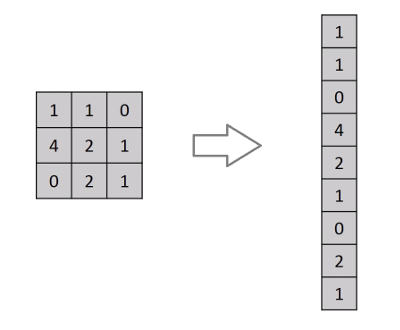

# Building a 1-layer fully connected network (FCN)


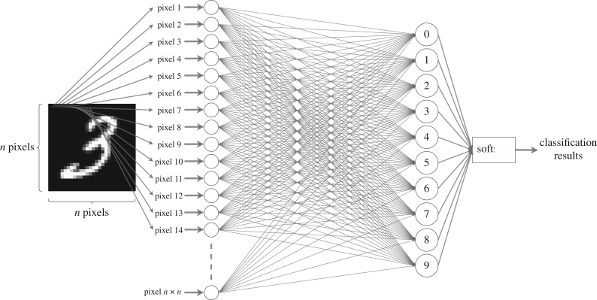

## Create the model architecture

There are two APIs for defining a model in Keras:
1. [Sequential model API](https://keras.io/models/sequential/)
2. [Functional API](https://keras.io/guides/functional_api/)

In this notebook we are using the Sequential model API. 

In defining the model we will be using some of these Keras APIs:
*   Conv2D() [link text](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D/) - create a convolutional layer 
*   Pooling() [link text](https://keras.io/layers/pooling/) - create a pooling layer 
*   Dropout() [link text](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) - apply drop out 

In [ ]:
# The Sequential model is a linear stack of layers and is very common.
model = tf.keras.models.Sequential()

In [ ]:
  #Flatten input
  model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))


## The first hidden layer

In [ ]:
  model.add(tf.keras.layers.Dense(128, activation='relu'))

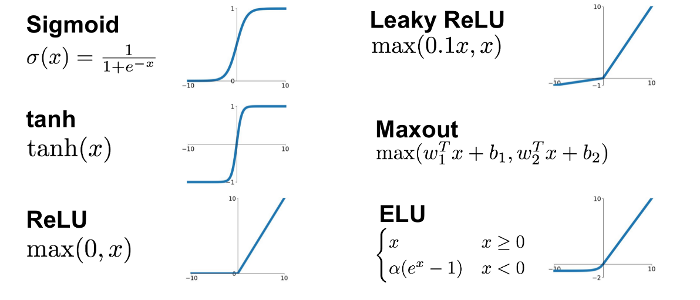

## The Final Output Layer

In [ ]:
model.add(tf.keras.layers.Dense(10))

In [ ]:
# Print model summary
model.summary()

### The model can also be written in below format

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])

In [ ]:
model.summary()

For each example the model returns a vector of "[logits](https://developers.google.com/machine-learning/glossary#logits)" or "[log-odds](https://developers.google.com/machine-learning/glossary#log-odds)" scores, one for each class.

In [ ]:
predictions = model(x_train[:1]).numpy()
predictions

The `tf.nn.softmax` function converts these logits to "probabilities" for each class: 

In [ ]:
tf.nn.softmax(predictions).numpy()

Note: It is possible to bake this `tf.nn.softmax` in as the activation function for the last layer of the network. While this can make the model output more directly interpretable, this approach is discouraged as it's impossible to
provide an exact and numerically stable loss calculation for all models when using a softmax output. 

The `losses.SparseCategoricalCrossentropy` loss takes a vector of logits and a `True` index and returns a scalar loss for each example.

In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

This loss is equal to the negative log probability of the true class:
It is zero if the model is sure of the correct class.

This untrained model gives probabilities close to random (1/10 for each class), so the initial loss should be close to `-tf.log(1/10) ~= 2.3`.

In [ ]:
loss_fn(y_train[:1], predictions).numpy()

2.1670141

## Compiling the model

Keras in TensorFlow packages allow you to define a *computation graph* in Python, which then compiles and runs efficiently on the CPU or GPU without the overhead of the Python interpreter.

When compiing a model, Keras in TensorFlow asks you to specify your **loss function** and your **optimizer**. The loss function we'll use here is called *Sparse Categorical Crossentropy*.

Our predictions are probability distributions across the ten different digits (e.g. "we're 80% confident this image is a 3, 10% sure it's an 8, 5% it's a 2, etc."), and the target is a probability distribution with 100% for the correct category, and 0 for everything else. The cross-entropy is a measure of how different your predicted distribution is from the target distribution. [More detail at Wikipedia](https://en.wikipedia.org/wiki/Cross_entropy)

The optimizer helps determine how quickly the model learns through **gradient descent**. The rate at which descends a gradient is called the **learning rate**.

In [ ]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

## Train the model!
This is the fun part! 

The batch size determines over how much data per step is used to compute the loss function, gradients, and back propagation. Large batch sizes allow the network to complete it's training faster; however, there are other factors beyond training speed to consider.

Too large of a batch size smoothes the local minima of the loss function, causing the optimizer to settle in one because it thinks it found the global minimum.

Too small of a batch size creates a very noisy loss function, and the optimizer may never find the global minimum.

So a good batch size may take some trial and error to find!

The `Model.fit` method adjusts the model parameters to minimize the loss: 

In [ ]:
model.fit(x_train, y_train, batch_size=32, epochs=10)

The `Model.evaluate` method checks the models performance, usually on a "[Validation-set](https://developers.google.com/machine-learning/glossary#validation-set)" or "[Test-set](https://developers.google.com/machine-learning/glossary#test-set)".

In [ ]:
model.evaluate(x_test,  y_test, verbose=2)

The image classifier is now trained to ~98% accuracy on this dataset. To learn more, read the [TensorFlow tutorials](https://www.tensorflow.org/tutorials/).

If you want your model to return a probability, you can wrap the trained model, and attach the softmax to it:

In [ ]:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

In [ ]:
probability_model(x_test[:5])

In [ ]:
np.round(probability_model(x_test[:5]),2)

test image shape :  (7, 28, 28)
inference image shape :  (7, 28, 28, 1)


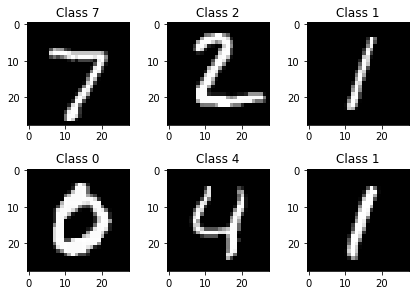

In [ ]:
# Predict single images
n_images = 6
# Get images from test set
test_images = x_test[:n_images+1]
print("test image shape : ",  (test_images.shape))
# Prepare the input data
img = (np.expand_dims(test_images,3))

print("inference image shape : ", img.shape)
# Use the model to predict the images class
preds = list(model.predict(img))

plt.rcParams['figure.figsize'] = (6,6) # Make the figures a bit bigger

for i in range(n_images):
    plt.subplot(3,3,i+1)
    plt.imshow(test_images[i], cmap='gray', interpolation='none')
    plt.title("Class {}".format(np.argmax(preds[i])))
    
plt.tight_layout()
